In [ ]:
!pip install -qq yellowbrick

In [ ]:
# some builtin imports
import re
import warnings
from collections import Counter
import time
from datetime import datetime
warnings.filterwarnings('ignore')

# Some usual imports here
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl


# sklearn models
from sklearn import metrics
from sklearn.svm import SVR
from sklearn import metrics, model_selection

# visualizations
import shap
from yellowbrick.regressor import residuals_plot, prediction_error

In [ ]:
## Customize Matplotlib Parameters
%matplotlib inline
mpl.rcParams['figure.dpi']= 120
mpl.rcParams['figure.edgecolor']= 'black'
mpl.rcParams['axes.linewidth']= .5
# Customize Seaborn Parameters
sns.set()
rc = {
      'font.family': ['serif'],
      'font.serif':'Times New Roman',
      'grid.color': 'gainsboro',
      'grid.linestyle': '-',
}
sns.set_style(rc=rc)
sns.set_context("notebook", font_scale=0.8)

In [ ]:
from google.colab import files
import pandas as pd

# Upload the file
uploaded = files.upload()

# Assuming you have uploaded a CSV file named 'house_rental_fin.csv'
# Read the uploaded file into a DataFrame
import io
df = pd.read_csv(io.BytesIO(uploaded['house_rental_fin.csv']))

# Display the first few rows
df.head()


Saving house_rental_fin.csv to house_rental_fin.csv


,category_Flats,category_Detached,category_Townhouse,category_Duplex,category_Mansion,category_Semi-Detached,bedrooms,bathrooms,floor_area,condition_Used,...,amenities_wi-fi,parking_space,lat,lng,amenities_count,furnishing_Semi-Furnished,furnishing_Unfurnished,furnishing_Furnished,price,log1p_price
0,1.0,0.0,0.0,0.0,0.0,0.0,-0.363125,-0.409811,-0.393436,1.0,...,1,0,-0.198154,0.264372,1.026783,1.0,0.0,0.0,9196,9.126633
1,1.0,0.0,0.0,0.0,0.0,0.0,-0.363125,-0.409811,-0.436503,1.0,...,1,0,-0.245904,0.158057,0.306848,0.0,1.0,0.0,7500,8.922792
2,0.0,1.0,0.0,0.0,0.0,0.0,1.220567,1.767869,-0.436503,0.0,...,0,0,-0.100510,0.339132,1.506740,1.0,0.0,0.0,11200,9.323758
3,0.0,1.0,0.0,0.0,0.0,0.0,0.428721,0.316082,-0.515938,1.0,...,0,0,-0.314007,0.440336,-0.893045,1.0,0.0,0.0,2500,7.824446
4,0.0,1.0,0.0,0.0,0.0,0.0,0.428721,0.316082,-0.379081,1.0,...,1,0,-0.194226,0.372127,1.026783,1.0,0.0,0.0,9146,9.121181


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17890 entries, 0 to 17889
Data columns (total 39 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   category_Flats                 17890 non-null  float64
 1   category_Detached              17890 non-null  float64
 2   category_Townhouse             17890 non-null  float64
 3   category_Duplex                17890 non-null  float64
 4   category_Mansion               17890 non-null  float64
 5   category_Semi-Detached         17890 non-null  float64
 6   bedrooms                       17890 non-null  float64
 7   bathrooms                      17890 non-null  float64
 8   floor_area                     17890 non-null  float64
 9   condition_Used                 17890 non-null  float64
 10  condition_New                  17890 non-null  float64
 11  condition_Renovated            17890 non-null  float64
 12  amenities_24-hour electricity  17890 non-null 

In [ ]:
def compute_metrics(model, x, y, cv=5):
    preds = model.predict(x)
    score = model.score(x, y)

    scores_cvs = model_selection.cross_val_score(model, x, y, scoring='r2', cv=cv)

    return pd.DataFrame([{
        "R2": round(score, 3),
        "mse": round(metrics.mean_squared_error(y, preds), 3),
        "rmse": round(np.sqrt(metrics.mean_squared_error(y, preds)), 3),
        "mae": round(metrics.mean_absolute_error(y, preds), 3),
        "adjusted_r2": round(1 - (1 - score) * (len(y) - 1) / (len(y) - x.shape[1] - 1), 3),
        "cv_score": round(scores_cvs.mean()*100, 2)
    }])

In [ ]:
# train-test split for model evaluation
X = df.drop(['price', 'log1p_price'], axis=1).values
y = df['log1p_price'].values

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, train_size=0.8, shuffle=True, random_state=42
)

In [ ]:
X_train.shape, X_test.shape

((14312, 37), (3578, 37))

In [ ]:
model = SVR()
model = model.fit(X_train, y_train)

In [ ]:
train_metrics = compute_metrics(model, X_train, y_train)
train_metrics

,R2,mse,rmse,mae,adjusted_r2,cv_score
0,0.84,0.207,0.455,0.327,0.839,81.04


In [ ]:
val_metrics = compute_metrics(model, X_test, y_test)
val_metrics

,R2,mse,rmse,mae,adjusted_r2,cv_score
0,0.819,0.239,0.489,0.361,0.817,78.7


In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.1, 0.5],
    'kernel': ['rbf', 'linear'],
}

grid_search = RandomizedSearchCV(
    estimator=SVR(), param_distributions=param_grid, refit=True, n_iter=50,
    verbose=3, cv=3, scoring='r2', n_jobs=-1
)
grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)
print("Best R2 score:", grid_search.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best hyperparameters: {'kernel': 'rbf', 'gamma': 0.1, 'C': 1}
Best R2 score: 0.8109496246048357


In [ ]:
best_model = grid_search.best_estimator_

train_metrics = compute_metrics(best_model, X_train, y_train)
train_metrics

,R2,mse,rmse,mae,adjusted_r2,cv_score
0,0.854,0.189,0.435,0.308,0.853,81.26


In [ ]:
val_metrics = compute_metrics(best_model, X_test, y_test)
val_metrics

,R2,mse,rmse,mae,adjusted_r2,cv_score
0,0.822,0.234,0.484,0.356,0.821,78.55


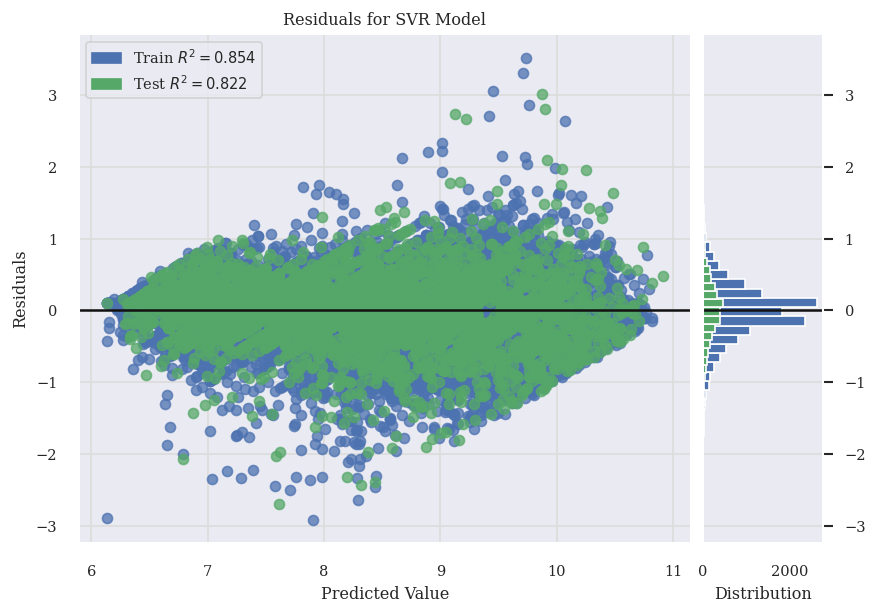

In [ ]:
visualizer = residuals_plot(
    best_model, X_train, y_train, X_test, y_test,
)

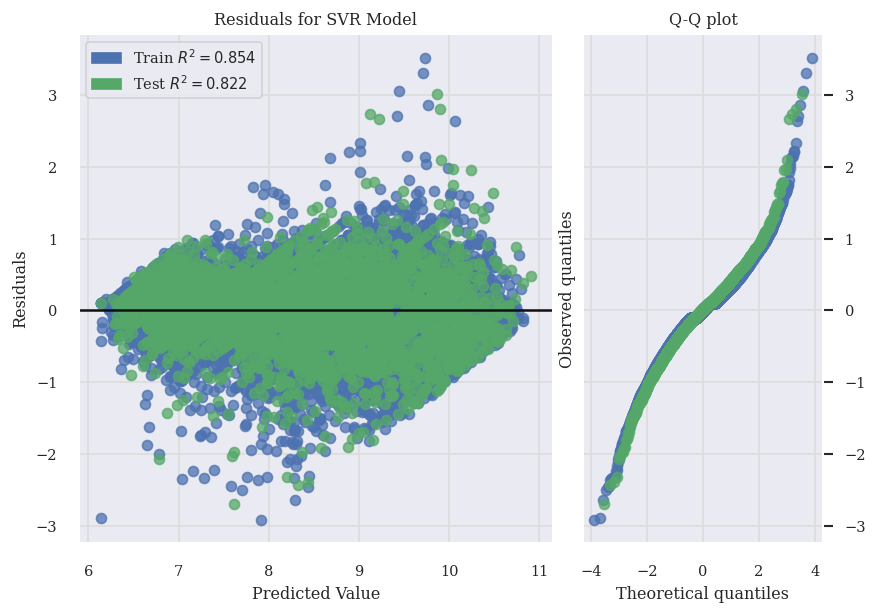

In [ ]:
visualizer = residuals_plot(
    best_model, X_train, y_train, X_test, y_test, hist=False, qqplot=True
)

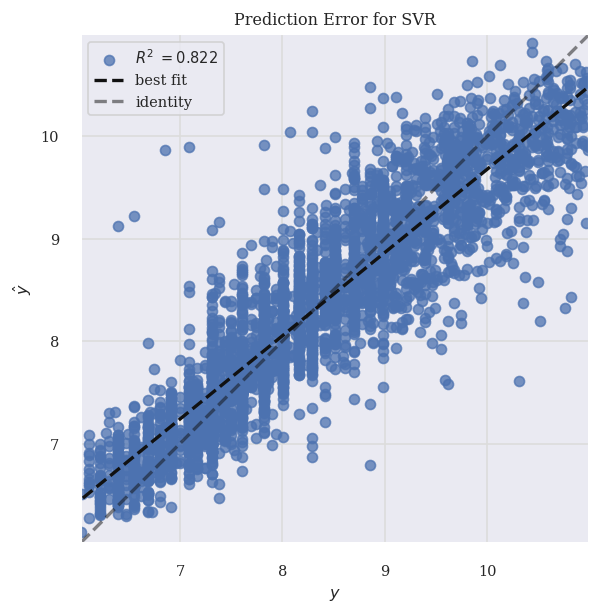

In [ ]:
visualizer = prediction_error(best_model, X_train, y_train, X_test, y_test)

In [ ]:
from sklearn.inspection import permutation_importance

In [ ]:
perm_importance = permutation_importance(best_model, X_test, y_test)
sorted_idx = perm_importance.importances_mean.argsort()

coef_df = pd.DataFrame(
    {
        "Variable": df.drop(['price', 'log1p_price'], axis=1).columns[sorted_idx],
        "Value": perm_importance.importances_mean[sorted_idx],
    }
)
n = 10
sorted_df = (
    coef_df.sort_values(by="Value", ascending=False)
    .head(n)
    .sort_values(by="Value")
)
sorted_df

,Variable,Value
27,furnishing_Unfurnished,0.017330
28,floor_area,0.017785
29,category_Flats,0.023287
30,furnishing_Furnished,0.039287
31,amenities_count,0.047438
32,amenities_air conditioning,0.075250
33,bathrooms,0.085844
34,lng,0.135511
35,lat,0.156854
36,bedrooms,0.229383


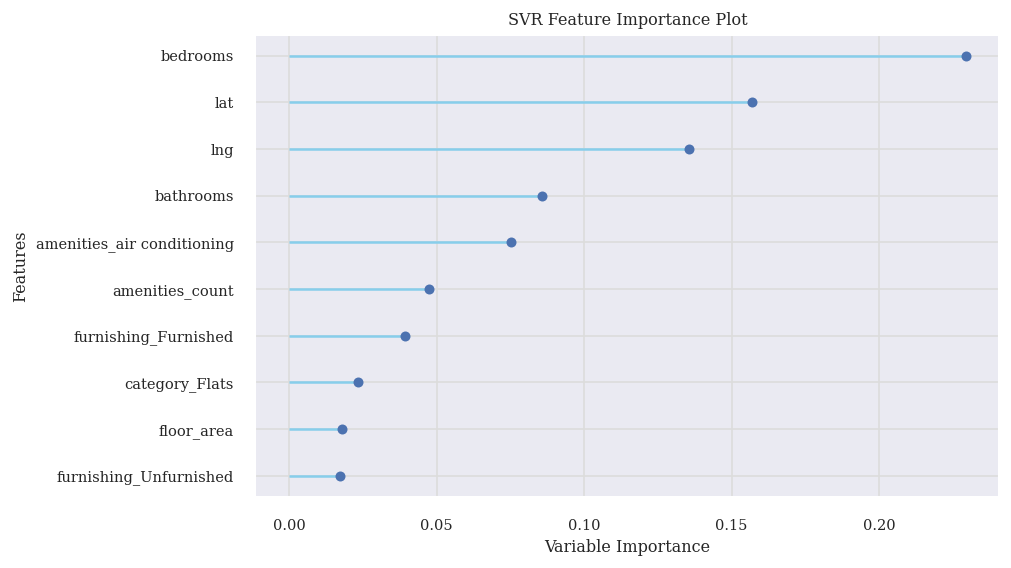

In [ ]:
my_range = range(1, len(sorted_df.index) + 1)
plt.figure(figsize=(8, 5 * (n // 10)))
plt.hlines(
    y=my_range,
    xmin=0,
    xmax=sorted_df["Value"],
    color="skyblue",
)
plt.plot(sorted_df["Value"], my_range, "o")
plt.yticks(my_range, sorted_df["Variable"])
plt.title("SVR Feature Importance Plot")
plt.xlabel("Variable Importance")
plt.ylabel("Features")
plt.show()

In [ ]:
preds = best_model.predict(X_test)

In [ ]:
# Reverse the log transformation
actual_preds = np.expm1(preds)
actual_y_test = np.expm1(y_test)

# Compute metrics on the original scale
def compute_metrics_original_scale(y_true, y_pred):
    return pd.DataFrame([{
        "R2": round(metrics.r2_score(y_true, y_pred), 3),
        "mse": round(metrics.mean_squared_error(y_true, y_pred), 3),
        "rmse": round(np.sqrt(metrics.mean_squared_error(y_true, y_pred)), 3),
        "mae": round(metrics.mean_absolute_error(y_true, y_pred), 3),
    }])

val_metrics_original_scale = compute_metrics_original_scale(actual_y_test, actual_preds)
val_metrics_original_scale

,R2,mse,rmse,mae
0,0.618,44433105.95,6665.816,3225.835


In [ ]:
pred_df = pd.DataFrame({"actual": actual_y_test, "pred": actual_preds})
pred_df.head(10)

,actual,pred
0,2000.0,2500.430398
1,2500.0,3468.096732
2,1500.0,1199.102755
3,1000.0,1004.229232
4,4000.0,9397.265977
5,3500.0,3512.605514
6,5000.0,3653.106928
7,3000.0,3776.195478
8,8000.0,11401.778057
9,1200.0,898.012608


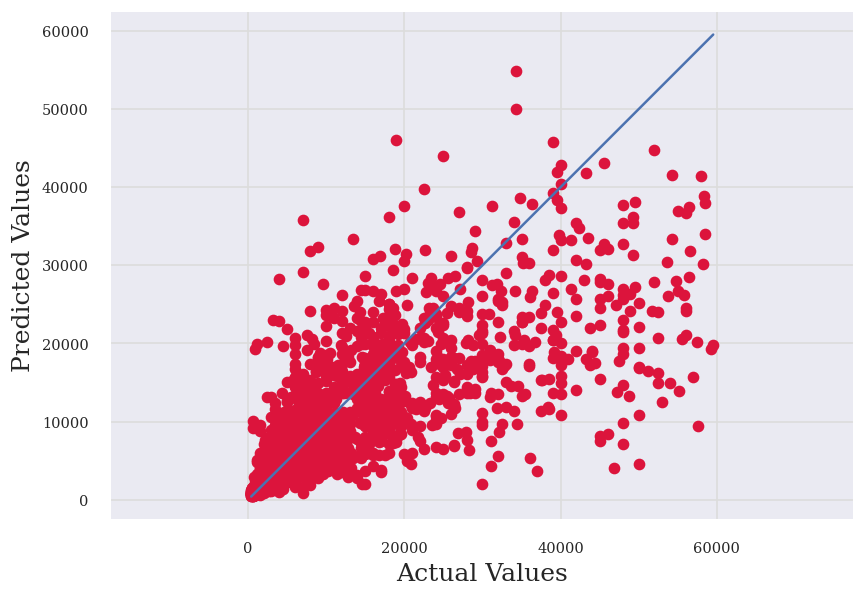

In [ ]:
plt.scatter(pred_df.actual, pred_df.pred, c='crimson')
p1 = max(max(pred_df.actual), max(pred_df.pred))
p2 = min(min(pred_df.actual), min(pred_df.pred))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Actual Values', fontsize=15)
plt.ylabel('Predicted Values', fontsize=15)
plt.axis('equal')
plt.show()

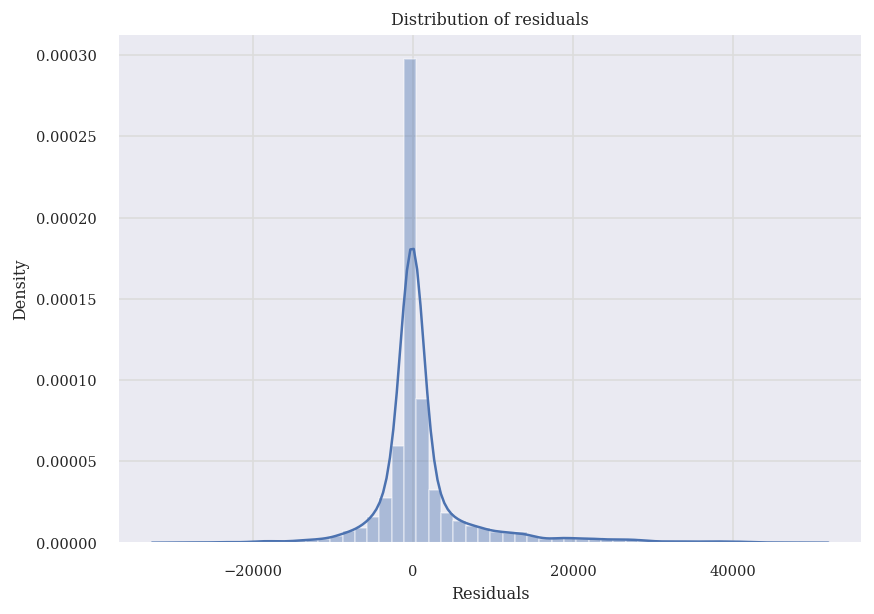

In [ ]:
sns.distplot((pred_df.actual-pred_df.pred))
plt.title('Distribution of residuals')
plt.xlabel("Residuals")
plt.show()